In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re
import time
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

----
# 1. Loading and Parsing Data

In [4]:
df = pd.read_csv('RLtest.csv', usecols=[1,2])

head() to see what the data looks like

In [5]:
df.head()

,host,class
0,boqaypuwee.yi.org,dga
1,fotoev.com,legit
2,quickfever.com,legit
3,weareplaystation.fr,legit
4,bxorruxhlkcb.pw,dga


In [6]:
N = df.shape[0]
P = df.shape[1]

print('Data has {} rows, {} columns'.format(N, P))

Data has 10000 rows, 2 columns


In [7]:
df.dtypes

host     object
class    object
dtype: object

In [8]:
list(df)

['host', 'class']

In [9]:
def get_domain(host):
    fullstr = host.split('.')
    domain = fullstr[0]
    return domain

df['domain'] = df['host'].apply(get_domain)
df['domain'][0:5]

0          boqaypuwee
1              fotoev
2          quickfever
3    weareplaystation
4        bxorruxhlkcb
Name: domain, dtype: object

In [10]:
df[0:5]

,host,class,domain
0,boqaypuwee.yi.org,dga,boqaypuwee
1,fotoev.com,legit,fotoev
2,quickfever.com,legit,quickfever
3,weareplaystation.fr,legit,weareplaystation
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb


In [11]:
df['class'].unique()

array(['dga', 'legit'], dtype=object)

In [12]:
df.describe()

,host,class,domain
count,10000,10000,10000
unique,9993,2,9986
top,secondhandhounds.org,legit,pubvn
freq,2,5715,2


### Read in the domains.csv data and print

In [13]:
df_test = pd.read_csv('domains.csv')
df_test.head()

,host,domain,class,subclass
0,000directory.com.ar,000directory,legit,legit
1,000webhost.com,000webhost,legit,legit
2,001fans.com,001fans,legit,legit
3,01-telecharger.com,01-telecharger,legit,legit
4,010shangpu.com,010shangpu,legit,legit


----
# 2. Creating some basic features with apply()

In [14]:
# create some features we think might help us figure out which domains are bad.

def string_length(s):
    length = len(s)
    return length

def string_number_count(s):
    numbers = sum(c.isdigit() for c in s)
    return numbers

def string_alpha_count(s):
    alpha = sum(c.isalpha() for c in s)
    return alpha

def others(s):
    numbers = sum(c.isdigit() for c in s)
    alpha = sum(c.isalpha() for c in s)
    others = len(s) - numbers - alpha
    return others

Use the apply function to create new feature columns

In [15]:
df['numbers'] = df['domain'].apply(string_number_count)
df['other_chars'] = df['domain'].apply(others)
df['alpha'] = df['domain'].apply(string_alpha_count)
df['length'] = df['domain'].apply(string_length)

In [16]:
df.head()

,host,class,domain,numbers,other_chars,alpha,length
0,boqaypuwee.yi.org,dga,boqaypuwee,0,0,10,10
1,fotoev.com,legit,fotoev,0,0,6,6
2,quickfever.com,legit,quickfever,0,0,10,10
3,weareplaystation.fr,legit,weareplaystation,0,0,16,16
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb,0,0,12,12


----
# 3. Explore the Data

In [17]:
df.describe()

,numbers,other_chars,alpha,length
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,0.45880,0.071100,12.669000,13.198900
std,2.11829,0.305703,5.444043,5.968878
min,0.00000,0.000000,0.000000,1.000000
25%,0.00000,0.000000,8.000000,9.000000
50%,0.00000,0.000000,12.000000,12.000000
75%,0.00000,0.000000,16.000000,17.000000
max,25.00000,5.000000,40.000000,42.000000


Understand how your input variables are distributed

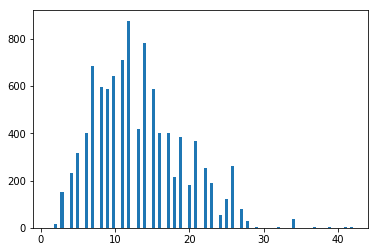

In [18]:
plt.hist(df['length'], bins=100)
plt.show()

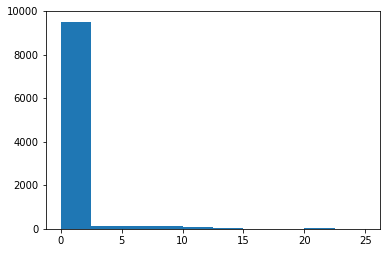

In [19]:
plt.hist(df['numbers'], bins=10)
plt.show()

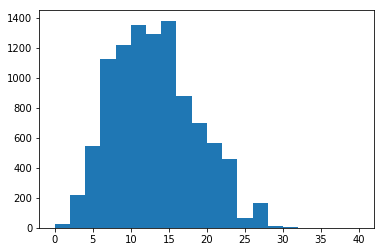

In [20]:
plt.hist(df['alpha'], bins=20)
plt.show()

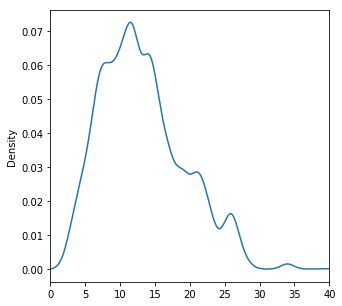

In [21]:
df['length'].plot(kind="density",
              figsize=(5,5), xlim=(0,40))

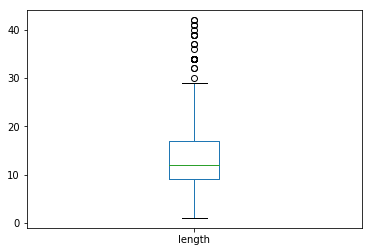

In [22]:
df['length'].plot(kind='box')

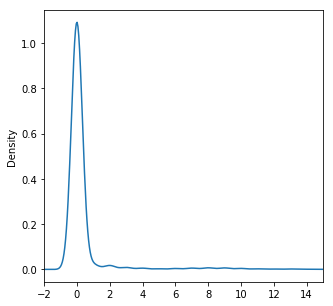

In [23]:
df['numbers'].plot(kind='density', figsize=(5,5), xlim=(-2,15))

In [24]:
def plot_ecdfs(data, fields, n=1000, prob_cutoff=0.01):
    '''plot empirical CDFs between probability range [prob_cutoff, 1.0-prob_cutoff]'''
    x = [(prob_cutoff + (1.0 - prob_cutoff * 2) * i / n) for i in range(n + 1)]
    nrows = np.ceil(len(fields) / 3)
    plt.figure(figsize=(16, 4 * nrows))
    for i, field in enumerate(fields):
        plt.subplot(nrows, 3, i + 1)
        plt.plot(data[field].quantile(x), x)
        plt.title(field)
        
def plot_hists(data, fields, bins=20, prob_cutoff=0.01):
    '''plot histograms for data whose empirical mass is in range [prob_cutoff, 1.0-prob_cutoff]'''
    nrows = np.ceil(len(fields) / 3)
    plt.figure(figsize=(16, 4 * nrows))
    for i, field in enumerate(fields):
        plt.subplot(nrows, 3, i + 1)
        min_val = data[field].quantile(prob_cutoff)
        max_val = data[field].quantile(1.0 - prob_cutoff)
        y = data[(data[field] >= min_val) & (data[field] <= max_val)][field]
        plt.hist(y, bins = bins)
        plt.title(field)

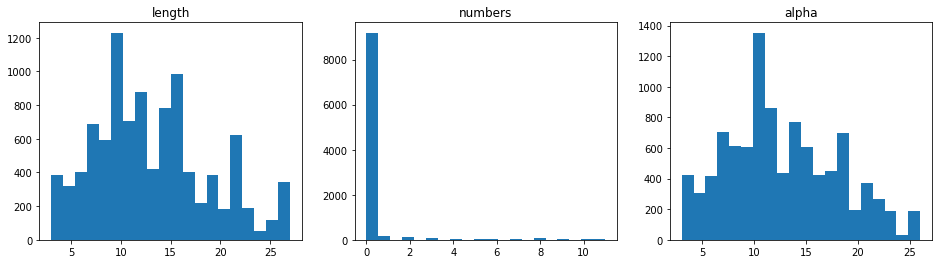

In [25]:
plot_hists(df, ['length', 'numbers', 'alpha'])

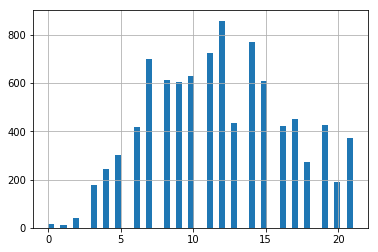

In [26]:
threshold = 0.90
threshold_val = df['alpha'].quantile(threshold)
df[df['alpha'] <= threshold_val]['alpha'].hist(bins=50)

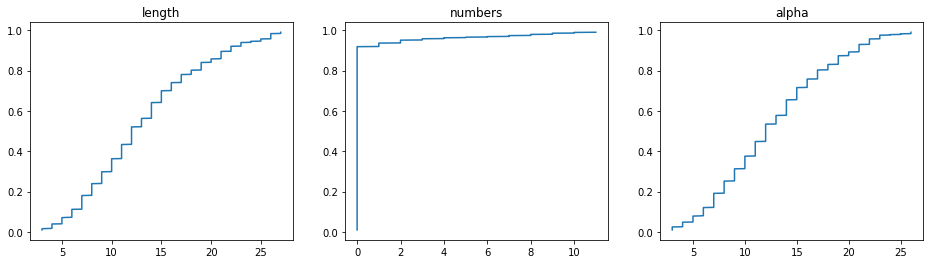

In [27]:
plot_ecdfs(df, ['length', 'numbers', 'alpha'])

----
# 4. Try to predict badness using a simple separator

Encode Target Variable

In [28]:
def is_bad(string):
    if string == 'dga':
        return 1
    else:
        return 0

df['is_bad']=df['class'].apply(is_bad)

In [29]:
df.head()

,host,class,domain,numbers,other_chars,alpha,length,is_bad
0,boqaypuwee.yi.org,dga,boqaypuwee,0,0,10,10,1
1,fotoev.com,legit,fotoev,0,0,6,6,0
2,quickfever.com,legit,quickfever,0,0,10,10,0
3,weareplaystation.fr,legit,weareplaystation,0,0,16,16,0
4,bxorruxhlkcb.pw,dga,bxorruxhlkcb,0,0,12,12,1


In [30]:
pd.crosstab(df['is_bad'], df['numbers'])

numbers,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
is_bad,,,,,,,,,,,,,,,,,,,,,
0,5335,159,125,54,31,7,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3855,15,21,20,16,17,33,47,60,56,...,4,3,4,5,6,8,2,7,5,1


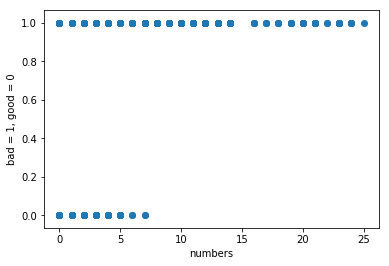

In [31]:
plt.scatter(df['numbers'],df['is_bad'])
plt.xlabel('numbers')
plt.ylabel('bad = 1, good = 0')
plt.show()

### Maybe numbers is a good separator, lets look at another variable

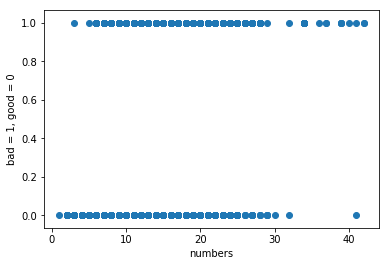

In [32]:
plt.scatter(df['length'],df['is_bad'])
plt.xlabel('numbers')
plt.ylabel('bad = 1, good = 0')
plt.show()

### What if we combine them?

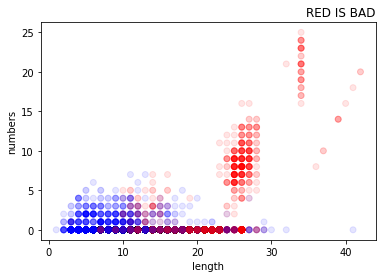

In [33]:
color= ['red' if c == 1 else 'blue' for c in df['is_bad']]
plt.scatter(df['length'],df['numbers'], color=color, alpha = .1)
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('RED IS BAD',loc='right')
plt.show()


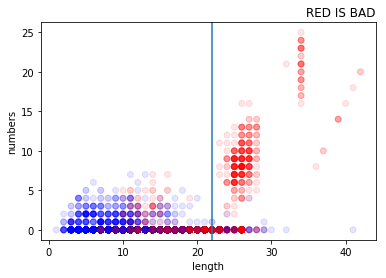

In [34]:
color= ['red' if c == 1 else 'blue' for c in df['is_bad']]
plt.scatter(df['length'],df['numbers'], color=color, alpha = .1)
plt.axvline(x=22)
plt.xlabel('length')
plt.ylabel('numbers')
plt.title('RED IS BAD',loc='right')
plt.show()


### Create a very simple model:

In [35]:
def separate(length):
    if length > 22:
        return 1
    else:
        return 0

df['model_1_pred']= df['length'].apply(separate)

In [36]:
y_pred = df['model_1_pred']
y_actual = df['is_bad']

from sklearn.metrics import accuracy_score

score = accuracy_score(y_actual, y_pred)
score

0.6378

#### Not so great...maybe we need some new features.

In [37]:
df = df.drop(['model_1_pred'], axis=1)

----
# 5. Supervised model creation

In [38]:
ignore_cols = set(['is_bad', 'subclass', 'class', 'domain', 'host', 'TLD', 'gibberish'])
features = list(set(df) - ignore_cols)
features

['alpha', 'other_chars', 'numbers', 'length']

In [39]:
df[features].dtypes.head()

alpha          int64
other_chars    int64
numbers        int64
length         int64
dtype: object

In [40]:
types = ['float', 'int', 'object']

for i in types:
    print(str(i) + "s: " + str(list(df.loc[:0, df.dtypes == i])))

floats: []
ints: ['numbers', 'other_chars', 'alpha', 'length', 'is_bad']
objects: ['host', 'class', 'domain']


In [41]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 


X= df[features]
y = df['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
print("Train Set Size: %d" % len(X_train))
print("Test Set Size: %d" % len(X_test))

Train Set Size: 9000
Test Set Size: 1000


In [42]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
start = time.time()
lm.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = lm.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.754000, Train Time: 0.012884, Predict Time: 0.000252


In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = rf.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.792000, Train Time: 0.035125, Predict Time: 0.001809


In [44]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = dt.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.793000, Train Time: 0.004660, Predict Time: 0.000522


In [45]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
start = time.time()
svc.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = svc.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.589000, Train Time: 0.293442, Predict Time: 0.000187


In [46]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
start = time.time()
nn.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = nn.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.753000, Train Time: 0.435068, Predict Time: 0.000773


In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
start = time.time()
knn.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = knn.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.767000, Train Time: 0.012075, Predict Time: 0.007275


---- 
### Moar features!  Let's add some more advanced features to our models and see what happens.

In [48]:
df1 = df.copy()

In [49]:
#extract the Top-Level-Domain
def find_tld(s):
    domains = s.split(".")
    tld = domains[-1]
    return tld

#truncate domains to reduce levels
def shorten(tld):
    return tld[:4]

#count vowels
vowels = ['a','e','i','o','u','y']
def vowel_count(string):
    vcount = 0
    for i in vowels:
        vcount += str(string).count(i)
    return vcount

#string entropy calculation: 
def entropy(string):
        #"Calculates the Shannon entropy of a string"
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])
        return entropy

#simply count # of domains
def num_domains(column):
    return str(column).count('.')+1


#potential exercise (find all consecutive substrings of 3+ non-vowels)
def find_gibberish(string):
    gibberish = []
    gibs = re.findall(r'[^aeiouy]{3,}', string)
    for j in gibs:
        gibberish.append(j)
    return gibberish

def list_len(column):
    return len(column)

def avg_len(column):
    total = 0
    for i in column:
        total += len(i)
    if len(column) > 0:
        return float(total)/len(column)
    else:
        return 0

def find_max(column):
    if len(column)>0:
        return len(max(column, key=len))
    else:
        return 0
    
df1['entropy'] = df1['domain'].apply(entropy)
df1['TLD'] = df1['host'].apply(find_tld)
df1['tld_length']=df1['TLD'].apply(string_length)
df1['vowel_count']=df1['domain'].apply(vowel_count)
df1['v_ratio']=df1['vowel_count']/df['length']
df1['num_domains']=df1['host'].apply(num_domains)
df1['num_density']=df1['numbers']/df['length']
df1['gibberish']=df1['domain'].apply(find_gibberish)
df1['gibberish_amount']=df1['gibberish'].apply(list_len)
df1['gibberish_avg']=df1['gibberish'].apply(avg_len)

In [50]:
features = list(set(df1) - ignore_cols)
features

['gibberish_amount',
 'entropy',
 'tld_length',
 'vowel_count',
 'num_density',
 'other_chars',
 'alpha',
 'num_domains',
 'v_ratio',
 'numbers',
 'gibberish_avg',
 'length']

In [51]:
X = df1[features]
y = df1['is_bad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
print("Train Set Size: %d" % len(X_train))
print("Test Set Size: %d" % len(X_test))

Train Set Size: 9000
Test Set Size: 1000


In [52]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression()
start = time.time()
lm.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = lm.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.891000, Train Time: 0.037694, Predict Time: 0.000462


In [53]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = rf.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.907000, Train Time: 0.073825, Predict Time: 0.003062


In [54]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = dt.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.904000, Train Time: 0.019799, Predict Time: 0.000497


In [55]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
start = time.time()
svc.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = svc.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.888000, Train Time: 0.433925, Predict Time: 0.000313


In [56]:
nn = MLPClassifier()
start = time.time()
nn.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = nn.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.895000, Train Time: 0.648495, Predict Time: 0.000797


In [57]:
knn = KNeighborsClassifier()
start = time.time()
knn.fit(X_train, y_train)
train_time = time.time() - start
start = time.time()
y_pred = knn.predict(X_test)
pred_time = time.time() - start
score = accuracy_score(y_test, y_pred)
print("Accuracy: %f, Train Time: %f, Predict Time: %f" % (score, train_time, pred_time))

Accuracy: 0.891000, Train Time: 0.011100, Predict Time: 0.014857


----
## 6. Evaluation Section


In [58]:
y_pred = lm.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[504,  53],
       [ 56, 387]])

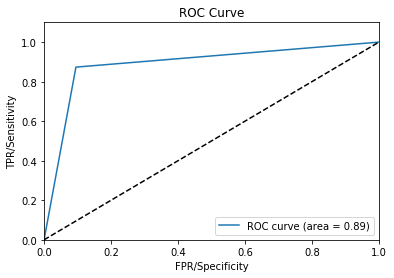

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([.0, 1.])
plt.ylim([.0, 1.1])
plt.xlabel('FPR/Specificity')
plt.ylabel('TPR/Sensitivity')
plt.title("ROC Curve")
plt.legend(loc = 'lower right')
plt.show()

In [61]:
from sklearn.metrics import classification_report
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.90      0.90       557
          1       0.88      0.87      0.88       443

avg / total       0.89      0.89      0.89      1000



Average precision-recall score: 0.82


Text(0.5,1,'2-class Precision-Recall curve: AP=0.82')

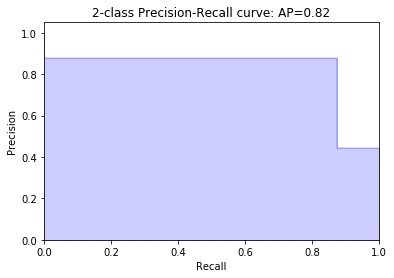

In [62]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [63]:
from sklearn.model_selection import cross_val_score
scores_final = cross_val_score(lm, X, y, scoring='accuracy')
print('CV Acc. {}, Average Acc. {}'.format(scores_final, scores_final.mean()))

CV Acc. [0.85752849 0.85508551 0.85238524], Average Acc. 0.8549997471252825


In [64]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}
scores_final = cross_validate(lm.fit(X,y), X, y, scoring=scoring)

for key in scores_final:
    print("%s: %s" % (key, str(scores_final[key])))

fit_time: [0.03444314 0.03109503 0.03075409]
score_time: [0.01710296 0.01912284 0.01677084]
test_tp: [1674 1631 1661]
train_tp: [3309 3318 3311]
test_tn: [1674 1631 1661]
train_tn: [3309 3318 3311]
test_fp: [244 209 248]
train_fp: [485 453 458]
test_fn: [231 274 244]
train_fn: [501 492 499]


In [65]:
df_test['numbers'] = df_test['domain'].apply(string_number_count)
df_test['other_chars'] = df_test['domain'].apply(others)
df_test['alpha'] = df_test['domain'].apply(string_alpha_count)
df_test['length'] = df_test['domain'].apply(string_length)
df_test['entropy'] = df_test['domain'].apply(entropy)
df_test['TLD'] = df_test['host'].apply(find_tld)
df_test['tld_length']=df_test['TLD'].apply(string_length)
df_test['vowel_count']=df_test['domain'].apply(vowel_count)
df_test['v_ratio']=df_test['vowel_count']/df_test['length']
df_test['num_domains']=df_test['host'].apply(num_domains)
df_test['num_density']=df_test['numbers']/df_test['length']
df_test['gibberish']=df_test['domain'].apply(find_gibberish)
df_test['gibberish_amount']=df_test['gibberish'].apply(list_len)
df_test['gibberish_avg']=df_test['gibberish'].apply(avg_len)

df_test['is_bad']= df_test['class'].apply(is_bad)

In [66]:
df_test_X = df_test[features]
df_test_y = df_test['is_bad']

df_test_pred = lm.predict(df_test_X)
score = accuracy_score(df_test_y, df_test_pred)
report = classification_report(df_test_y, df_test_pred)
print("Accuracy: %f" % (score))
print(report)

Accuracy: 0.895771
             precision    recall  f1-score   support

          0       0.94      0.88      0.91     81261
          1       0.83      0.92      0.87     52665

avg / total       0.90      0.90      0.90    133926



----
# 7. Model Troubleshooting

Start by looking at what some of our more interpretable models have learned.  Parameters from the logistic regression model, and the learned decision tree.

In [67]:
for a, b in zip(features, lm.coef_[0]):
    print(a, b)

gibberish_amount -0.04419708006085878
entropy 1.3595172981461583
tld_length 0.43578666991974857
vowel_count -0.2106734463241417
num_density -4.050646005243965
other_chars -3.934089152178164
alpha 1.3937888175831323
num_domains -2.3196113737828887
v_ratio -1.5104302710349902
numbers 1.369437899545649
gibberish_avg 0.41187890978745245
length -1.1708624350507215


In [68]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(dt, out_file=None, feature_names=features)
graph = graphviz.Source(dot_data) 
graph

Plot learning and validation curves to understand the impact of training data size and hyperparameter settings on performance.

In [69]:
# plot learning curves  - Scott
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

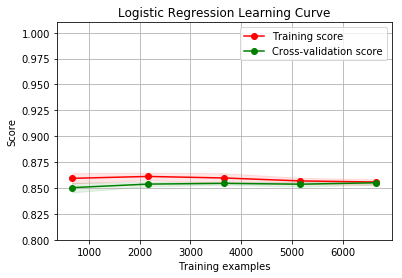

In [70]:
new_lm = LogisticRegression()
plot_learning_curve(new_lm, "Logistic Regression Learning Curve", X, y, ylim=(0.8, 1.01))
plt.show()

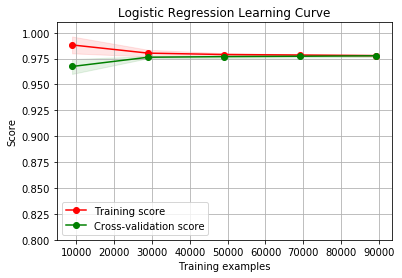

In [71]:
new_lm = LogisticRegression()
plot_learning_curve(new_lm, "Logistic Regression Learning Curve", df_test_X, df_test_y, ylim=(0.8, 1.01))
plt.show()

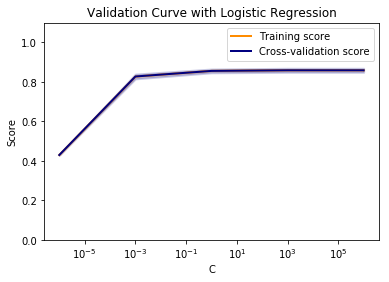

In [72]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve

new_lm=LogisticRegression()

param_range = np.logspace(-6, 6, 5)
train_scores, test_scores = validation_curve(
    new_lm, X, y, param_name="C", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

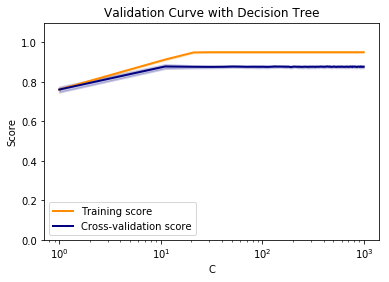

In [73]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import validation_curve

new_lm=DecisionTreeClassifier()

param_range = range(1, 1000, 10)
train_scores, test_scores = validation_curve(
    new_lm, X, y, param_name="max_depth", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Tree")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Now, let's take a look at some concrete examples from the data to try and understand what it is learning (and why the model is so good despite minimal training data).

In [74]:
df[df['class']=='dga'].sample(20)

,host,class,domain,numbers,other_chars,alpha,length,is_bad
6486,1vlpqw052scukgqnv3f1jhuvx.org,dga,1vlpqw052scukgqnv3f1jhuvx,6,0,19,25,1
7084,kkfpinalcentricem.com,dga,kkfpinalcentricem,0,0,17,17,1
4897,eaorsdia.sx,dga,eaorsdia,0,0,8,8,1
3857,ntrnsemitismgavenuteq.com,dga,ntrnsemitismgavenuteq,0,0,21,21,1
1135,nvfppartbulkyf.com,dga,nvfppartbulkyf,0,0,14,14,1
6688,tpisvinskycattederifg.com,dga,tpisvinskycattederifg,0,0,21,21,1
7090,pfmfererwyatanb.com,dga,pfmfererwyatanb,0,0,15,15,1
3186,jtjxcsd40bwo21e21h54o31p22pui35jqbqcub18.info,dga,jtjxcsd40bwo21e21h54o31p22pui35jqbqcub18,16,0,24,40,1
3153,bdzpestnessbiophysicalohax.com,dga,bdzpestnessbiophysicalohax,0,0,26,26,1
6520,rhmkxaqruuujw.us,dga,rhmkxaqruuujw,0,0,13,13,1


Take a random sample of our FPs and FNs to see if we can tease out any trends.

In [76]:
import random
y_pred = lm.predict(X_test)
incorrect = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred[i]]
fp_list = []
fn_list = []
for i in incorrect:
    if y_test.iloc[i] == 0:
        fp_list.append(i)
    else:
        fn_list.append(i)
fn_list = random.sample(fn_list, 10)
fp_list = random.sample(fp_list, 10)

In [77]:
df.iloc[X_test.iloc[fn_list].index]

,host,class,domain,numbers,other_chars,alpha,length,is_bad
2075,eqoyeaaogndagprj.bz,dga,eqoyeaaogndagprj,0,0,16,16,1
1107,dvbycitiybjw.org,dga,dvbycitiybjw,0,0,12,12,1
9414,lgghiiiphctc.eu,dga,lgghiiiphctc,0,0,12,12,1
6516,dokujas.su,dga,dokujas,0,0,7,7,1
7968,lnujererwyatanb.com,dga,lnujererwyatanb,0,0,15,15,1
735,gokzyilac.kz,dga,gokzyilac,0,0,9,9,1
1617,pzenererwyatanb.com,dga,pzenererwyatanb,0,0,15,15,1
7388,oqogorcajanunal.com,dga,oqogorcajanunal,0,0,15,15,1
4631,qyejotagg.com,dga,qyejotagg,0,0,9,9,1
5572,ttyuepictom.com,dga,ttyuepictom,0,0,11,11,1


In [78]:
X_test.iloc[fn_list]

,gibberish_amount,entropy,tld_length,vowel_count,num_density,other_chars,alpha,num_domains,v_ratio,numbers,gibberish_avg,length
2075,2,3.327820,2,8,0.0,0,16,2,0.500000,0,3.5,16
1107,2,3.084963,3,4,0.0,0,12,2,0.333333,0,3.0,12
9414,2,2.688722,2,3,0.0,0,12,2,0.250000,0,4.5,12
6516,0,2.807355,2,3,0.0,0,7,2,0.428571,0,0.0,7
7968,0,3.373557,3,6,0.0,0,15,2,0.400000,0,0.0,15
735,0,3.169925,2,4,0.0,0,9,2,0.444444,0,0.0,9
1617,0,3.189898,3,6,0.0,0,15,2,0.400000,0,0.0,15
7388,0,3.139572,3,7,0.0,0,15,2,0.466667,0,0.0,15
4631,0,2.947703,3,4,0.0,0,9,2,0.444444,0,0.0,9
5572,0,3.027169,3,5,0.0,0,11,2,0.454545,0,0.0,11


In [79]:
df.iloc[X_test.iloc[fp_list].index]

,host,class,domain,numbers,other_chars,alpha,length,is_bad
4302,clixcrafts.com,legit,clixcrafts,0,0,10,10,0
7653,safarnevesht.com,legit,safarnevesht,0,0,12,12,0
4822,milfthreesomes.com,legit,milfthreesomes,0,0,14,14,0
5764,electroniccircuits.gr,legit,electroniccircuits,0,0,18,18,0
9001,todohostingweb.com,legit,todohostingweb,0,0,14,14,0
3434,worldwidedictionary.org,legit,worldwidedictionary,0,0,19,19,0
5537,arkdiscovery.com,legit,arkdiscovery,0,0,12,12,0
1578,zanzisgrovecity.com,legit,zanzisgrovecity,0,0,15,15,0
1862,powershardware.com,legit,powershardware,0,0,14,14,0
7728,bestbookbriefings.com,legit,bestbookbriefings,0,0,17,17,0


In [80]:
X_test.iloc[fp_list]

,gibberish_amount,entropy,tld_length,vowel_count,num_density,other_chars,alpha,num_domains,v_ratio,numbers,gibberish_avg,length
4302,2,3.121928,3,2,0.0,0,10,2,0.200000,0,3.0,10
7653,1,3.084963,3,4,0.0,0,12,2,0.333333,0,3.0,12
4822,1,3.182006,3,5,0.0,0,14,2,0.357143,0,5.0,14
5764,1,3.127987,2,7,0.0,0,18,2,0.388889,0,3.0,18
9001,1,3.324863,3,5,0.0,0,14,2,0.357143,0,3.0,14
3434,1,3.431624,3,8,0.0,0,19,2,0.421053,0,4.0,19
5537,1,3.418296,3,5,0.0,0,12,2,0.416667,0,3.0,12
1578,1,3.640224,3,6,0.0,0,15,2,0.400000,0,3.0,15
1862,2,3.039149,3,5,0.0,0,14,2,0.357143,0,3.0,14
7728,3,3.337175,3,6,0.0,0,17,2,0.352941,0,3.0,17
